# 互评作业三：基于 K-means 的文本聚类

姓名：

学号：

代码仓库：

任务：本作业将通过 K-means 算法对 20 Newsgroups 数据集中的文本数据进行聚类。首先是数据的预处理，提取文本特征；然后将数据转换为特征向量，使用 K-means 算法进行聚类；最后对聚类结果进行评估和可视化分析。

数据集：[20 Newsgroups](http://qwone.com/~jason/20Newsgroups/)

要求：

1. 数据预处理：去除停用词、数字、符号等，提取文本特征。
2. 特征向量化：将预处理后的文本使用 TF-IDF 方法进行向量化。
3. K-means 模型训练：根据设定的 K 值，构建 K-means 模型，并对向量化的文本数据进行聚类。
4. 聚类结果分析：评估聚类结果，可使用轮廓系数、CH 指数等方法。
5. 可视化：使用降维方法（如 PCA 或 t-SNE）将高维数据降维至 2 D 或 3 D，然后进行可视化，观察聚类效果。

可以观察到 20 Newsgroups 数据集中共有 20 类数据，我们使用其中的三个进行实验。

在本次作业中，使用 `scikit-learn` 包进行文本的聚类，接下来先引用包：

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import sys
from time import time

import pandas as pd
import numpy as np

# 一、数据预处理

## 1.1 数据读取

不妨从 $20$ 类数据中挑选出其中的 $3$ 个进行实验。采用的分别为 `tal.religion.misc`、`comp.graphics`、`sci.space` 这三个数据类别。

In [2]:
# Selected 3 categories from the 20 newsgroups dataset

categories = [
    'rec.sport.baseball',
    'comp.graphics',
    'talk.politics.guns',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['rec.sport.baseball', 'comp.graphics', 'talk.politics.guns']


此处去除数据中的头尾以及引用，仅保留正文部分。标签可以看出仅有 $3$ 类。

In [3]:
df = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))
df.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
labels = df.target
true_k = len(np.unique(labels)) ## This should be 3 in this example
print(true_k)

3


In [5]:
len(df.data)

2877

## 1.2 词形还原

使用 `nltk.stem.WordNetLemmatizer` 做词形还原

In [6]:
lemmatizer = WordNetLemmatizer()
for i in range(len(df.data)):
    word_list = word_tokenize(df.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    df.data[i] = lemmatized_doc  

In [7]:
print(df.data[1])

 Um , the header said *career . * Hodapp managed about 3000 PA in his nine year in the major . As for his `` consistently over .300 , '' make that `` three year in a row , preceded by a part-time year , plus his last year , with Boston . '' Hodapp only qualified for the batting title five time . Was he injured ? He retired right around his 28th birthday . Anyway , Hodapp put up flashy number the year *everybody* put up flashy number . That wa his only really good year with a bat ; his other .300 year were marred by a lack of power and an inability to draw walk . Only 163 of those 3000 PA were base on ball , which doe not describe a feared hitter . On the other hand , he wa part of the long line of famous Cleveland 2B : Wambsganss , Riggs Stephenson , etc .


# 二、数据向量化

## 2.1 TF-IDF

接下来将语料转化为 TF-IDF 向量。本处也去除了停用词、低频率出现的项（许多都是数字或者是错别字）、还有一些变音符号。不妨取 `min_df` $=5$。

In [8]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=5) ## Corpus is in English
X = vectorizer.fit_transform(df.data)

In [9]:
print(X.shape)

(2877, 6001)


# 三、K-means 模型训练

## 3.1 K-means

首先使用标准的 k-means 算法进行聚类文档。K-means 的核心参数就是 $k$，然而选择 $k$ 的初始值没有固定的准则。

本次试验中，由于原本取的数据类共 $3$ 类，因此设定 $k=3$。

In [10]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=10000)
t0 = time()
km.fit(X)
print("共计耗时 %0.3fs" % (time() - t0))

共计耗时 0.598s


## 四、聚类结果分析

这里共使用 $5$ 中指标来评估聚类，同质性、完全性、V-measure、调整兰德系数、轮廓系数。

In [11]:
print("同质性 Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("完全性 Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("同质性和完全性的调和平均 V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("调整兰德系数 Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("轮廓系数 Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

同质性 Homogeneity: 0.457
完全性 Completeness: 0.508
同质性和完全性的调和平均 V-measure: 0.481
调整兰德系数 Adjusted Rand-Index: 0.371
轮廓系数 Silhouette Coefficient: 0.011


在每个聚类中 $10$ 个最相关的项

In [12]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: wa gun people just did think ha right fbi like
Cluster 1: game year team wa player hit run pitcher baseball think
Cluster 2: file image thanks program format know graphic graphics bit looking


# 五、可视化

## 5.1 每个聚类中 $10$ 个最相关的项可视化词云

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [14]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [15]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

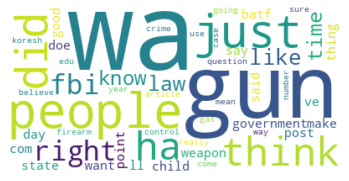

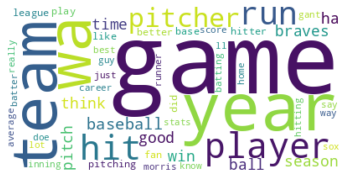

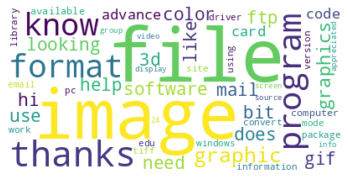

In [16]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()

## 5.2 数据分布可视化

本实验使用 PCA 做降维后的可视化。

In [17]:
X_embedded = PCA(n_components=2).fit_transform(X.toarray())
# X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(2877, 2)

得到每一组数据的聚类编号

In [18]:
predict = km.predict(X)
predict, predict.shape

(array([1, 1, 0, ..., 2, 0, 0], dtype=int32), (2877,))

### 5.2.1 原本数据降维图像

In [19]:
x = [[[], [], []], [[], [], []]]
for i in range(len(predict)):
    x[0][df["target"][i]].append(X_embedded[i][0])
    x[1][df["target"][i]].append(X_embedded[i][1])
#     x[2][df["target"][i]].append(X_embedded[i][2])

for i in range(3):
    print(f"len x[0][{i}] = {len(x[0][i])}, len x[1][{i}] = {len(x[1][i])}")

len x[0][0] = 973, len x[1][0] = 973
len x[0][1] = 994, len x[1][1] = 994
len x[0][2] = 910, len x[1][2] = 910


In [20]:
print(df["target"])
print(len(df["target"]))

[1 1 0 ... 0 2 1]
2877


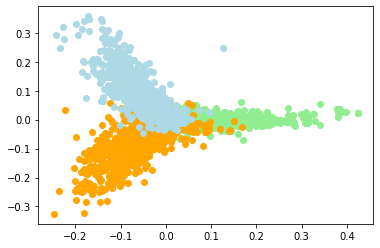

In [21]:
for i, color in zip(range(3), ["lightgreen", "orange", "lightblue"]):
    plt.scatter(x[0][i], x[1][i], c=color, marker='o')
plt.show()

### 5.2.2 聚类后降维图像

len x[0][0] = 1605, len x[1][0] = 1605
len x[0][1] = 551, len x[1][1] = 551
len x[0][2] = 721, len x[1][2] = 721


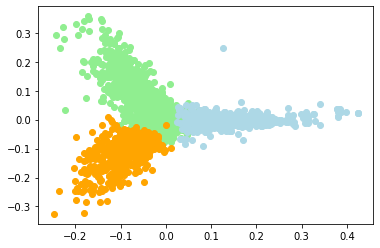

In [22]:
x = [[[], [], []], [[], [], []]]
for i in range(len(predict)):
    x[0][predict[i]].append(X_embedded[i][0])
    x[1][predict[i]].append(X_embedded[i][1])
#     x[2][predict[i]].append(X_embedded[i][2])

for i in range(3):
    print(f"len x[0][{i}] = {len(x[0][i])}, len x[1][{i}] = {len(x[1][i])}")
    
for i, color in zip(range(3), ["lightgreen", "orange", "lightblue"]):
    plt.scatter(x[0][i], x[1][i], c=color, marker='o')
plt.show()